In [37]:
#Check tf version
import tensorflow as tf
#print(tf.__version__)

#The following force you to use tensorflow 2.14 but you need to restart. You may comment it if you know you are using 2.14
!pip3 install --upgrade tensorflow==2.14.0
print(tf.__version__)

2.14.0


In [38]:
#imports
import os
import numpy as np
import tensorflow as tf
#tf.compat.v1.enable_eager_execution()
#print('Eager execution:', tf.executing_eagerly())
print(tf.__version__)
import matplotlib.pyplot as plt
import datetime
import pickle
import pandas as pd
import random

# set random seed to be used all over
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.compat.v1.set_random_seed(SEED)
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1,log_device_placement =True)
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = config)


2.14.0
Device mapping: no known devices.


In [39]:
# Path to the directory containing the project files (CHANGE THIS PATH TO THE DIRECTORY ON YOUR COMPUTER)
PROJECT_ROOT_DIR = os.getcwd() + '/'

# Path to the directory containing the dataset relative to project file
DATA_DIR = './GTSRB_dataset(1)/GTSRB_dataset/'

#path to the directory you want to use for saving models relative to the project file
MODEL_DIR = './'

In [40]:
# Funciton for loading the dataset
# Code from advml-traffic-sign (https://github.com/inspire-group/advml-traffic-sign)
def load_dataset_GTSRB(n_channel=3, train_file_name=None):
    """
    Load GTSRB data as a (datasize) x (channels) x (height) x (width) numpy
    matrix. Each pixel is rescaled to the range [0,1].
    """

    def load_pickled_data(file, columns):
        """
        Loads pickled training and test data.

        Parameters
        ----------
        file    : string
                          Name of the pickle file.
        columns : list of strings
                          List of columns in pickled data we're interested in.

        Returns
        -------
        A tuple of datasets for given columns.
        """

        with open(file, mode='rb') as f:
            dataset = pickle.load(f)
        return tuple(map(lambda c: dataset[c], columns))

    def preprocess(x, n_channel):
        """
        Preprocess dataset: turn images into grayscale if specified, normalize
        input space to [0,1], reshape array to appropriate shape for NN model
        """

        if n_channel == 3:
            # Scale features to be in [0, 1]
            x = (x / 255.).astype(np.float32)
        else:
            # Convert to grayscale, e.g. single Y channel
            x = 0.299 * x[:, :, :, 0] + 0.587 * x[:, :, :, 1] + \
                0.114 * x[:, :, :, 2]
            # Scale features to be in [0, 1]
            x = (x / 255.).astype(np.float32)
            x = x[:, :, :, np.newaxis]
        return x

    # Load pickle dataset
    if train_file_name is None:
        x_train, y_train = load_pickled_data(
            PROJECT_ROOT_DIR + DATA_DIR + 'train.p', ['features', 'labels'])
    else:
        x_train, y_train = load_pickled_data(
            PROJECT_ROOT_DIR + DATA_DIR + train_file_name, ['features', 'labels'])
    x_val, y_val = load_pickled_data(
        PROJECT_ROOT_DIR + DATA_DIR + 'valid.p', ['features', 'labels'])
    x_test, y_test = load_pickled_data(
        PROJECT_ROOT_DIR + DATA_DIR + 'test.p', ['features', 'labels'])

    # Preprocess loaded data
    x_train = preprocess(x_train, n_channel)
    x_val = preprocess(x_val, n_channel)
    x_test = preprocess(x_test, n_channel)
    return x_train, y_train, x_val, y_val, x_test, y_test

In [41]:
# Load the images and labels. These images are RGB so we have 3 channels
imgs_train, labels_train, imgs_val, labels_val, imgs_test, labels_test = load_dataset_GTSRB(n_channel=3)

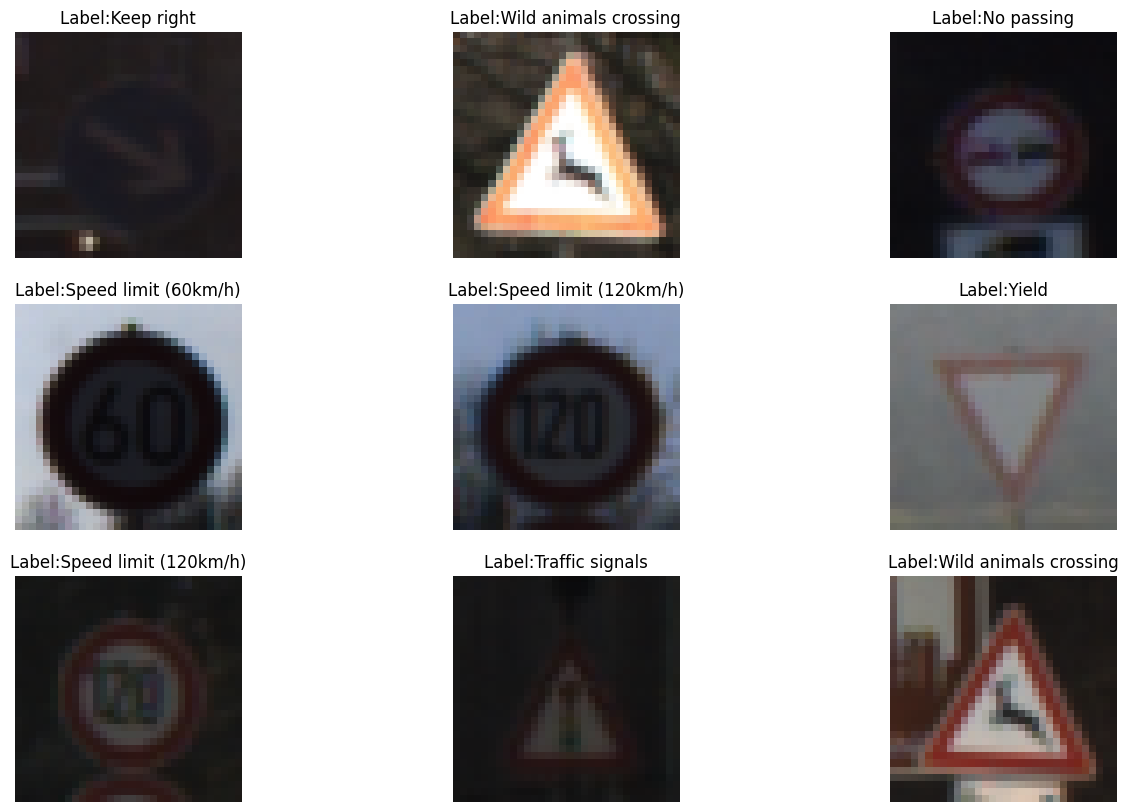

In [42]:
# Read the sign names
signnames = pd.read_csv(PROJECT_ROOT_DIR + './GTSRB_dataset(1)/GTSRB_dataset/signnames.csv').values[:, 1]

# Plot a few images to check if the data makes sense (note that the quality of some of the images is pretty low)
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(imgs_train), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(imgs_train[i[0]])
    plt.title('Label:' + str(signnames[labels_train[i[0]]]))
    plt.axis('off')

In [43]:
# Set constants (GTSRB)
NUM_LABELS = 43                             # Number of labels or classes for classification
BATCH_SIZE = 128                            # Size of batch
HEIGHT = 32                                 # Height of input image
WIDTH = 32                                  # Width of input image
N_CHANNEL = 3                               # Number of channels
OUTPUT_DIM = 43                             # Number of output dimension

# Set training hyperparameters
NUM_EPOCH = 50                             # Number of epoch to train
LR = 0.0002                                 # Learning rate
RBW = True #restore best weights
PATIENCE = 5# how many epochs between improvements

INPUT_SHAPE = (HEIGHT, WIDTH, N_CHANNEL)  # Input shape of model
IMG_SHAPE = (HEIGHT, WIDTH, N_CHANNEL)

In [44]:
#avoiding future overfitting
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss',
                   patience = PATIENCE,
                   restore_best_weights=RBW)]

In [45]:
# setting up labels
from tensorflow.keras.utils import to_categorical

#Convert the labels to one-hot encoding (to input to the models)

#make a copy of 500 test images before we encode for adversarial testing.
imgs_adv = imgs_test[0:500,:,:,:].copy()
labels_adv = labels_test[0:500].copy()




labels_train_cat = to_categorical(labels_train, NUM_LABELS)
labels_test_cat = to_categorical(labels_test, NUM_LABELS)
labels_val_cat = to_categorical(labels_val, NUM_LABELS)

#for testing adversarial inputs
labels_adv_cat = to_categorical(labels_adv,NUM_LABELS)

print('Labels train shape: {}'.format(labels_train.shape))
print('Labels train catagorical shape: {}\n'.format(labels_train_cat.shape))
print('Labels Adver shape: {}'.format(labels_adv.shape))
print('Labels Adver catagorical shape: {}'.format(labels_adv_cat.shape))

print('Imgs Adver shape: {}'.format(imgs_adv.shape))

Labels train shape: (34799,)
Labels train catagorical shape: (34799, 43)

Labels Adver shape: (500,)
Labels Adver catagorical shape: (500, 43)
Imgs Adver shape: (500, 32, 32, 3)


In [46]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model


#create our model
def build_model():
    #create VGG16 model with properties we want.
    base_model = tf.keras.applications.VGG16(include_top=False,
                                    weights="imagenet",
                                    input_shape=INPUT_SHAPE)

    #create fully connected layers
    #by not including the top we need to create these layers ourselves
    #input and output layers
    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add a fully-connected layer
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    # Add a softmax layer with 43 classes
    predictions = Dense(OUTPUT_DIM, activation='softmax', name ='softmax')(x)

    # The model
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])



    return model



In [47]:
# Training the model

##It will take alot of time to train the model. Thus, uncomment the following, build the model, save it and comment it back in your next run
## the code to save the move is available next.
'''
model = build_model()

t = datetime.datetime.now()

#fit the model
history = model.fit(x= imgs_train,
    y= labels_train_cat,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCH,
    # monitoring validation loss and metrics
    validation_data=(imgs_val, labels_val_cat),
    verbose=1,
    callbacks=callbacks)

print('Training time: %s\n' % (datetime.datetime.now() - t))



# Evaluate on train,validation,test images
t = datetime.datetime.now()
evals_test = model.evaluate(imgs_test, labels_test_cat)
print("Classification Accuracy Test: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))



t = datetime.datetime.now()
evals_test = model.evaluate(imgs_val, labels_val_cat)
print("Classification Accuracy Validation: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))



t = datetime.datetime.now()
evals_test = model.evaluate(imgs_train, labels_train_cat)
print("Classification Accuracy Train: ", evals_test[1])
print('Inference time: %s' % (datetime.datetime.now() - t))
'''

'\nmodel = build_model()\n\nt = datetime.datetime.now()\n\n#fit the model\nhistory = model.fit(x= imgs_train,\n    y= labels_train_cat,\n    batch_size=BATCH_SIZE,\n    epochs=NUM_EPOCH,\n    # monitoring validation loss and metrics\n    validation_data=(imgs_val, labels_val_cat),\n    verbose=1,\n    callbacks=callbacks)\n\nprint(\'Training time: %s\n\' % (datetime.datetime.now() - t))\n\n\n\n# Evaluate on train,validation,test images\nt = datetime.datetime.now()\nevals_test = model.evaluate(imgs_test, labels_test_cat)\nprint("Classification Accuracy Test: ", evals_test[1])\nprint(\'Inference time: %s \n\' % (datetime.datetime.now() - t))\n\n\n\nt = datetime.datetime.now()\nevals_test = model.evaluate(imgs_val, labels_val_cat)\nprint("Classification Accuracy Validation: ", evals_test[1])\nprint(\'Inference time: %s \n\' % (datetime.datetime.now() - t))\n\n\n\nt = datetime.datetime.now()\nevals_test = model.evaluate(imgs_train, labels_train_cat)\nprint("Classification Accuracy Train: "

In [48]:
## Load the saved the model
from tensorflow.keras.models import load_model


#The followiwng line should be uncommented with your first run (to save the model)
#model.save(MODEL_DIR +'VGG_best.keras')


#load our already trained model
# Your earlier directories should change to match this one
#You should be able to load the model once trained. The following line is used for that.
model = load_model( MODEL_DIR +'vgg_best.h5')



In [49]:
tf.compat.v1.disable_eager_execution()

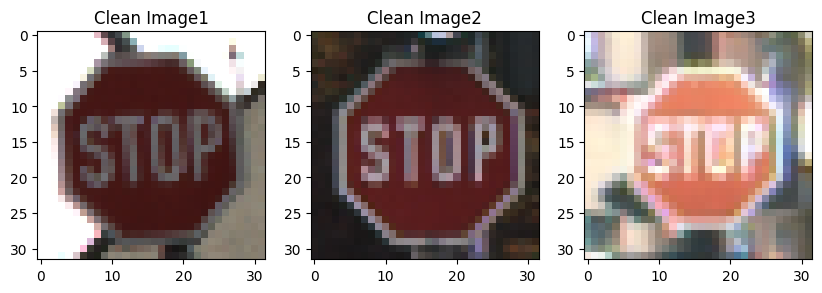

C:\Users\SRUTHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Accuracy on adversarial test data: 39.63%
Average perturbation: 0.05


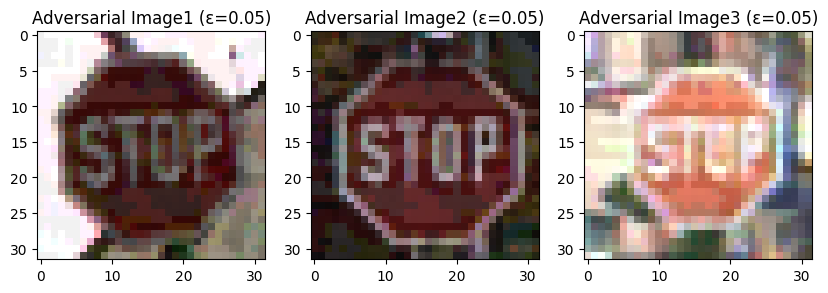

Accuracy on adversarial test data: 1.85%
Average perturbation: 0.09


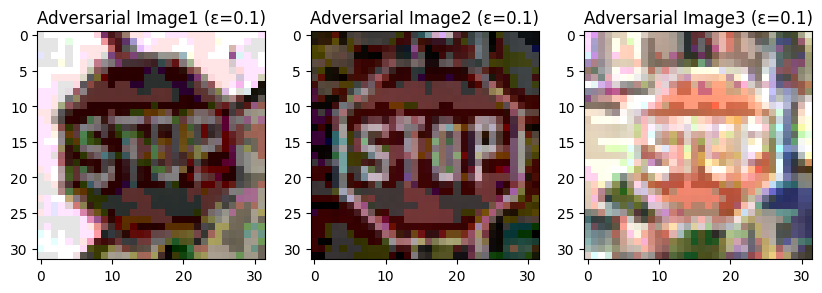

Accuracy on adversarial test data: 0.00%
Average perturbation: 0.18


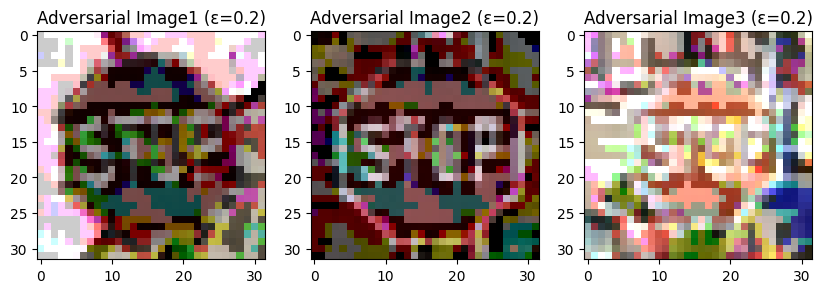

Accuracy on adversarial test data: 0.00%
Average perturbation: 0.21


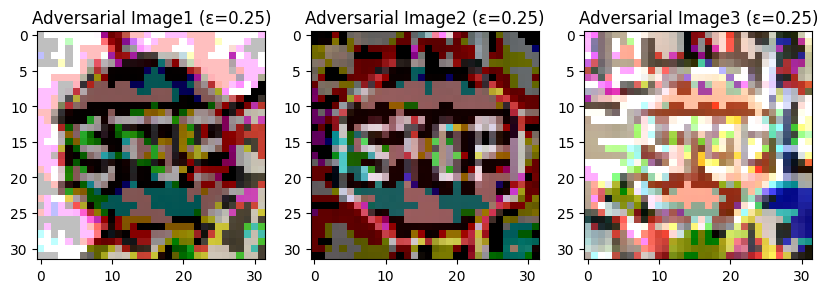

Accuracy on adversarial test data: 0.00%
Average perturbation: 0.25


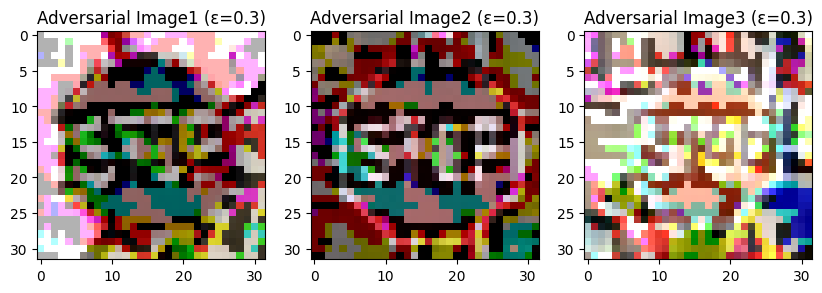

In [28]:
#Get your correct imports
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod

epsilon_values=[0.05,0.1,0.2,0.25,0.3]
STOP_SIGN_LABEL = np.where(signnames == 'Stop')[0][0]
stop_sign_indices = np.where(labels_test == STOP_SIGN_LABEL)[0]
imgs_stop_signs = imgs_test[stop_sign_indices]
labels_stop_signs = labels_test[stop_sign_indices]
labels_stop_signs = to_categorical(labels_stop_signs,43)

#Create the ART classifier
classifier = KerasClassifier(model=model, clip_values=(0, 1))
labels_ = to_categorical(labels_adv)
plt.figure(figsize=(10, 5)) 
plt.subplot(1, 3, 1) 
plt.imshow(imgs_stop_signs[0]) 
plt.title(f'Clean Image1')
plt.subplot(1, 3, 2) 
plt.imshow(imgs_stop_signs[1]) 
plt.title(f'Clean Image2')
plt.subplot(1, 3, 3) 
plt.imshow(imgs_stop_signs[3]) 
plt.title(f'Clean Image3')
plt.show()

for i in epsilon_values:
    #Create the ART attacker
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=i)
    imgs_adv_fgsm_stop_signs = attack_fgsm.generate(imgs_stop_signs)
    #Generate the results
    loss_test, accuracy_test = model.evaluate(imgs_adv_fgsm_stop_signs, labels_stop_signs)
    perturbation = np.mean(np.abs((imgs_adv_fgsm_stop_signs - imgs_stop_signs)))
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))
    #Save the results
    plt.figure(figsize=(10, 5))  
    plt.subplot(1, 3, 1) 
    plt.imshow(imgs_adv_fgsm_stop_signs[0]) 
    plt.title(f'Adversarial Image1 (ε={i})')
    plt.subplot(1, 3, 2) 
    plt.imshow(imgs_adv_fgsm_stop_signs[1]) 
    plt.title(f'Adversarial Image2 (ε={i})')
    plt.subplot(1, 3, 3) 
    plt.imshow(imgs_adv_fgsm_stop_signs[3]) 
    plt.title(f'Adversarial Image3 (ε={i})')
    plt.show()

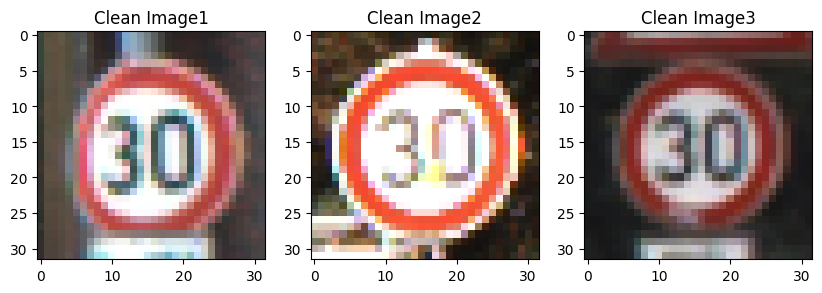

Accuracy on adversarial test data: 30.69%
Average perturbation: 0.05


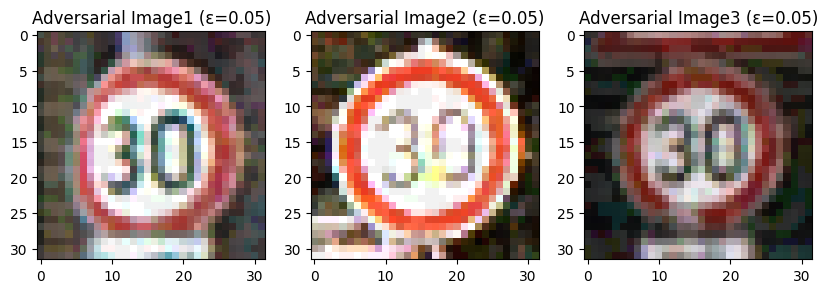

Accuracy on adversarial test data: 2.08%
Average perturbation: 0.10


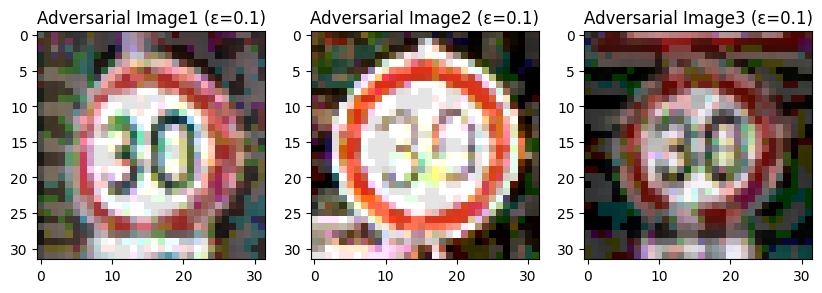

Accuracy on adversarial test data: 1.53%
Average perturbation: 0.18


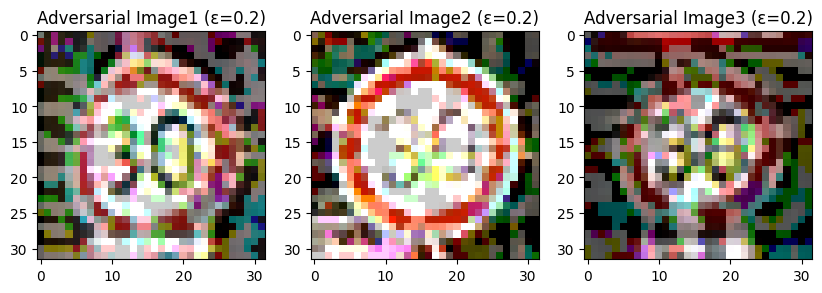

Accuracy on adversarial test data: 1.39%
Average perturbation: 0.22


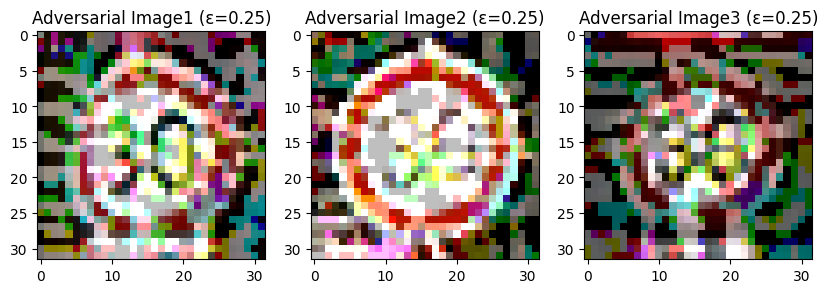

Accuracy on adversarial test data: 1.39%
Average perturbation: 0.25


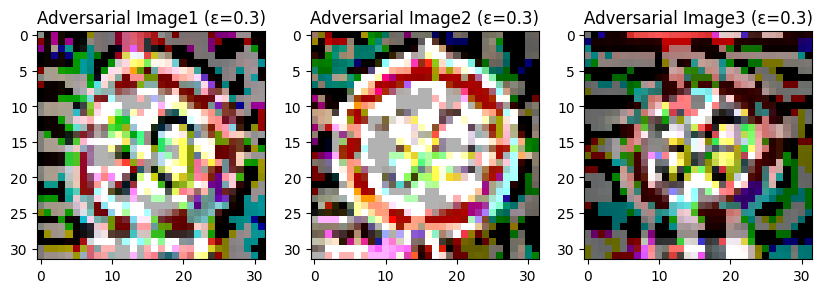

In [29]:
#Get your correct imports
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod

epsilon_values=[0.05,0.1,0.2,0.25,0.3]
STOP_SIGN_LABEL = np.where(signnames == 'Speed limit (30km/h)')[0][0]
stop_sign_indices = np.where(labels_test == STOP_SIGN_LABEL)[0]
imgs_stop_signs = imgs_test[stop_sign_indices]
labels_stop_signs = labels_test[stop_sign_indices]
labels_stop_signs = to_categorical(labels_stop_signs,43)

#Create the ART classifier
classifier = KerasClassifier(model=model, clip_values=(0, 1))
labels_ = to_categorical(labels_adv)
plt.figure(figsize=(10, 5)) 
plt.subplot(1, 3, 1) 
plt.imshow(imgs_stop_signs[0]) 
plt.title(f'Clean Image1')
plt.subplot(1, 3, 2) 
plt.imshow(imgs_stop_signs[1]) 
plt.title(f'Clean Image2')
plt.subplot(1, 3, 3) 
plt.imshow(imgs_stop_signs[3]) 
plt.title(f'Clean Image3')
plt.show()

for i in epsilon_values:
    #Create the ART attacker
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=i)
    imgs_adv_fgsm_stop_signs = attack_fgsm.generate(imgs_stop_signs)
    #Generate the results
    loss_test, accuracy_test = model.evaluate(imgs_adv_fgsm_stop_signs, labels_stop_signs)
    perturbation = np.mean(np.abs((imgs_adv_fgsm_stop_signs - imgs_stop_signs)))
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))
    #Save the results
    plt.figure(figsize=(10, 5))  
    plt.subplot(1, 3, 1) 
    plt.imshow(imgs_adv_fgsm_stop_signs[0]) 
    plt.title(f'Adversarial Image1 (ε={i})')
    plt.subplot(1, 3, 2) 
    plt.imshow(imgs_adv_fgsm_stop_signs[1]) 
    plt.title(f'Adversarial Image2 (ε={i})')
    plt.subplot(1, 3, 3) 
    plt.imshow(imgs_adv_fgsm_stop_signs[3]) 
    plt.title(f'Adversarial Image3 (ε={i})')
    plt.show()

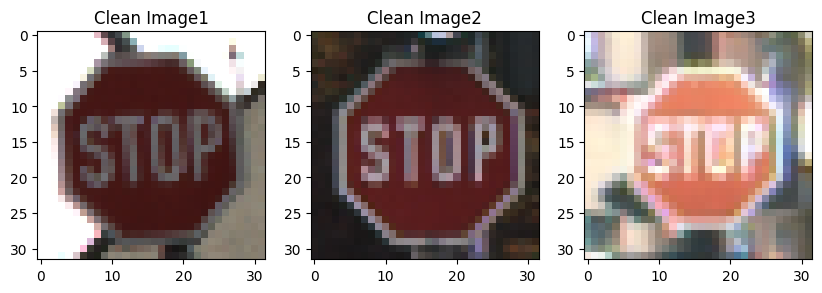

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

Accuracy on adversarial test data: 4.07%
Average perturbation: 0.04


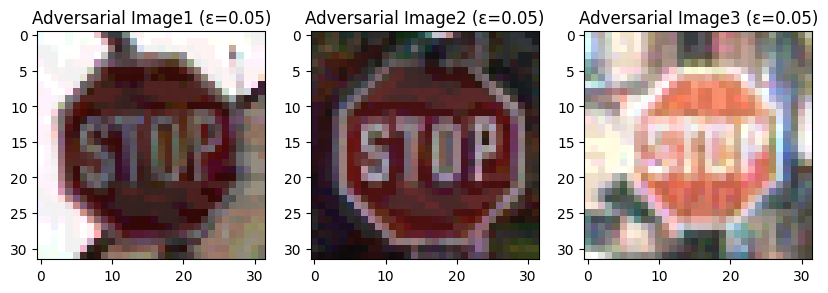

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

Accuracy on adversarial test data: 2.22%
Average perturbation: 0.07


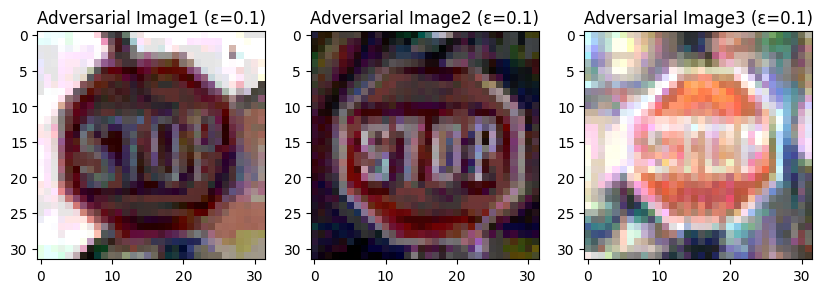

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

Accuracy on adversarial test data: 2.22%
Average perturbation: 0.11


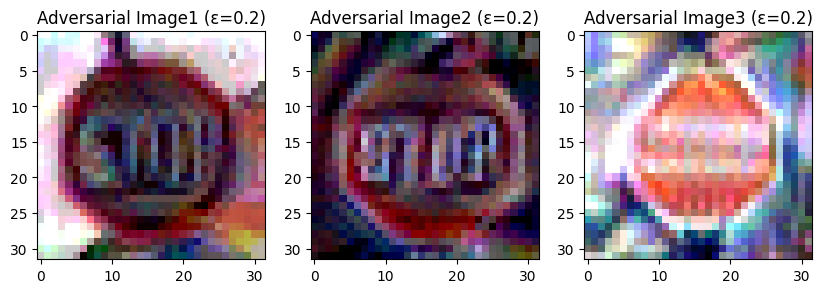

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

Accuracy on adversarial test data: 2.22%
Average perturbation: 0.12


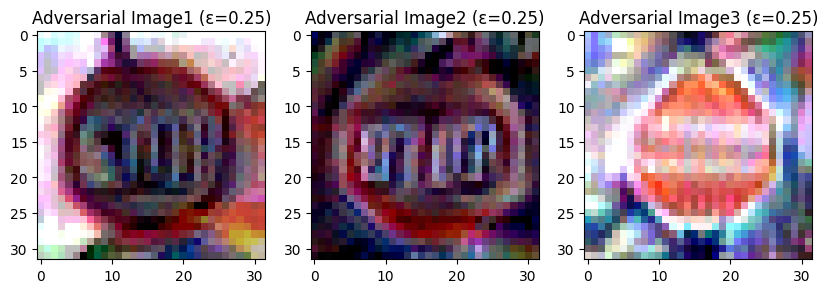

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

Accuracy on adversarial test data: 2.22%
Average perturbation: 0.12


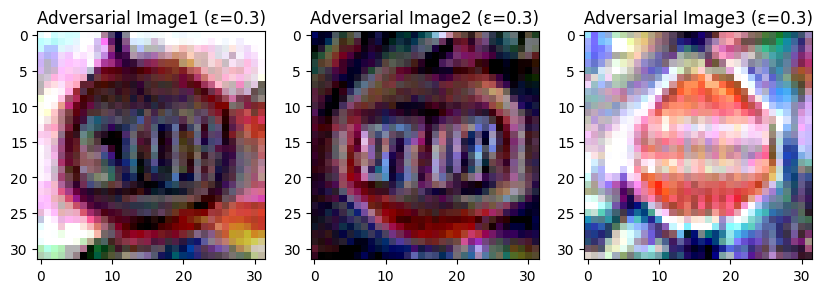

In [30]:
#Get your correct imports
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent

epsilon_values=[0.05,0.1,0.2,0.25,0.3]
STOP_SIGN_LABEL = np.where(signnames == 'Stop')[0][0]
stop_sign_indices = np.where(labels_test == STOP_SIGN_LABEL)[0]
imgs_stop_signs = imgs_test[stop_sign_indices]
labels_stop_signs = labels_test[stop_sign_indices]
labels_stop_signs = to_categorical(labels_stop_signs,43)

#Create the ART classifier
classifier = KerasClassifier(model=model, clip_values=(0, 1))
labels_ = to_categorical(labels_adv)
plt.figure(figsize=(10, 5)) 
plt.subplot(1, 3, 1) 
plt.imshow(imgs_stop_signs[0]) 
plt.title(f'Clean Image1')
plt.subplot(1, 3, 2) 
plt.imshow(imgs_stop_signs[1]) 
plt.title(f'Clean Image2')
plt.subplot(1, 3, 3) 
plt.imshow(imgs_stop_signs[3]) 
plt.title(f'Clean Image3')
plt.show()

for i in epsilon_values:
    #Create the ART attacker
    attack_pgd = ProjectedGradientDescent(estimator=classifier, 
                                       eps=i,      
                                       eps_step=0.01,
                                       max_iter=40)
    imgs_adv_pgd_stop_signs = attack_pgd.generate(imgs_stop_signs)
    #Generate the results
    loss_test, accuracy_test = model.evaluate(imgs_adv_pgd_stop_signs, labels_stop_signs)
    perturbation = np.mean(np.abs((imgs_adv_pgd_stop_signs - imgs_stop_signs)))
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))
    #Save the results
    plt.figure(figsize=(10, 5))  
    plt.subplot(1, 3, 1) 
    plt.imshow(imgs_adv_pgd_stop_signs[0]) 
    plt.title(f'Adversarial Image1 (ε={i})')
    plt.subplot(1, 3, 2) 
    plt.imshow(imgs_adv_pgd_stop_signs[1]) 
    plt.title(f'Adversarial Image2 (ε={i})')
    plt.subplot(1, 3, 3) 
    plt.imshow(imgs_adv_pgd_stop_signs[3]) 
    plt.title(f'Adversarial Image3 (ε={i})')
    plt.show()

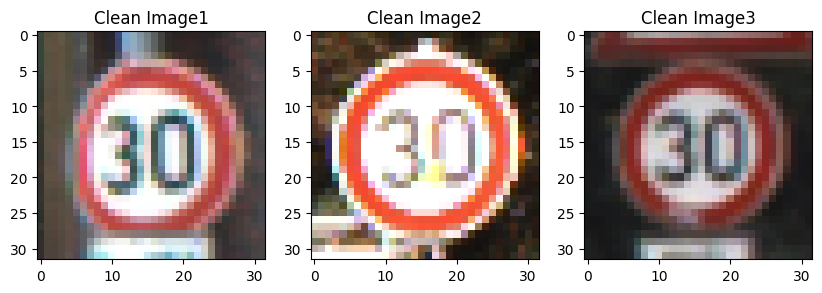

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

Accuracy on adversarial test data: 3.89%
Average perturbation: 0.04


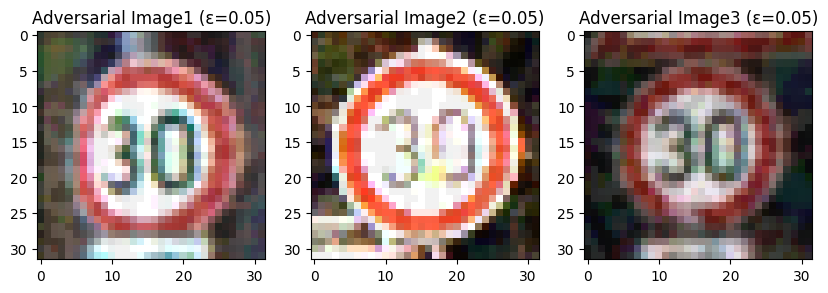

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

Accuracy on adversarial test data: 0.00%
Average perturbation: 0.08


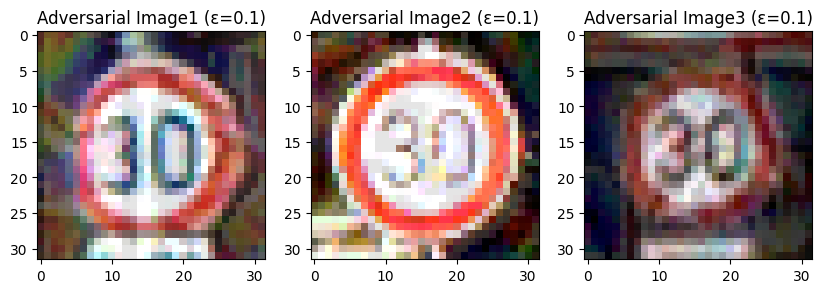

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

Accuracy on adversarial test data: 0.00%
Average perturbation: 0.11


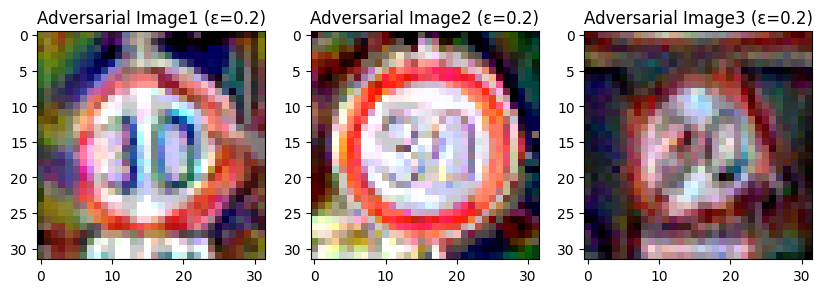

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

Accuracy on adversarial test data: 0.00%
Average perturbation: 0.12


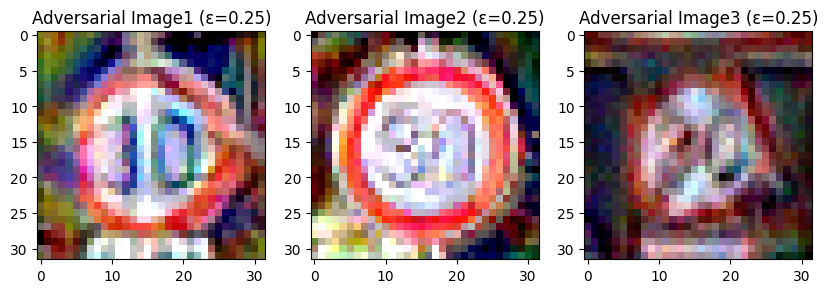

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

Accuracy on adversarial test data: 0.00%
Average perturbation: 0.13


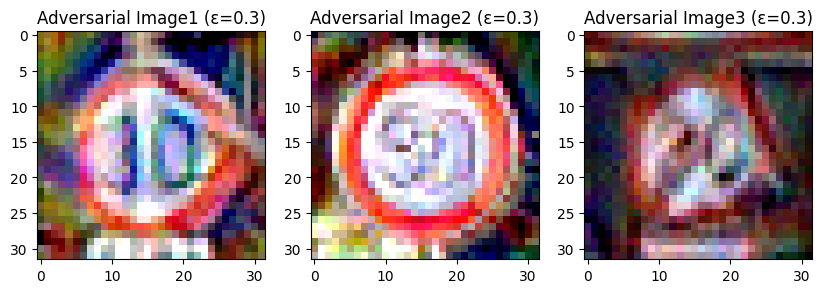

In [31]:
#Get your correct imports
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent

epsilon_values=[0.05,0.1,0.2,0.25,0.3]
STOP_SIGN_LABEL = np.where(signnames == 'Speed limit (30km/h)')[0][0]
stop_sign_indices = np.where(labels_test == STOP_SIGN_LABEL)[0]
imgs_stop_signs = imgs_test[stop_sign_indices]
labels_stop_signs = labels_test[stop_sign_indices]
labels_stop_signs = to_categorical(labels_stop_signs,43)

#Create the ART classifier
classifier = KerasClassifier(model=model, clip_values=(0, 1))
labels_ = to_categorical(labels_adv)
plt.figure(figsize=(10, 5)) 
plt.subplot(1, 3, 1) 
plt.imshow(imgs_stop_signs[0]) 
plt.title(f'Clean Image1')
plt.subplot(1, 3, 2) 
plt.imshow(imgs_stop_signs[1]) 
plt.title(f'Clean Image2')
plt.subplot(1, 3, 3) 
plt.imshow(imgs_stop_signs[3]) 
plt.title(f'Clean Image3')
plt.show()

for i in epsilon_values:
    #Create the ART attacker
    attack_pgd = ProjectedGradientDescent(estimator=classifier, 
                                       eps=i,      
                                       eps_step=0.01,
                                       max_iter=40)
    imgs_adv_pgd_stop_signs = attack_pgd.generate(imgs_stop_signs)
    #Generate the results
    loss_test, accuracy_test = model.evaluate(imgs_adv_pgd_stop_signs, labels_stop_signs)
    perturbation = np.mean(np.abs((imgs_adv_pgd_stop_signs - imgs_stop_signs)))
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))
    #Save the results
    plt.figure(figsize=(10, 5))  
    plt.subplot(1, 3, 1) 
    plt.imshow(imgs_adv_pgd_stop_signs[0]) 
    plt.title(f'Adversarial Image1 (ε={i})')
    plt.subplot(1, 3, 2) 
    plt.imshow(imgs_adv_pgd_stop_signs[1]) 
    plt.title(f'Adversarial Image2 (ε={i})')
    plt.subplot(1, 3, 3) 
    plt.imshow(imgs_adv_pgd_stop_signs[3]) 
    plt.title(f'Adversarial Image3 (ε={i})')
    plt.show()

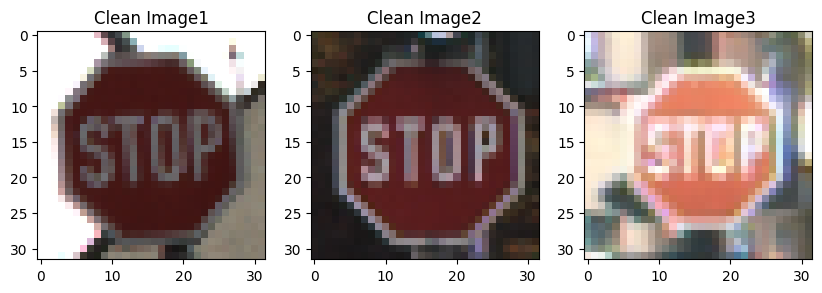

C&W L_2:   0%|          | 0/270 [00:00<?, ?it/s]

Accuracy on adversarial test data: 44.07%
Average perturbation: 0.03


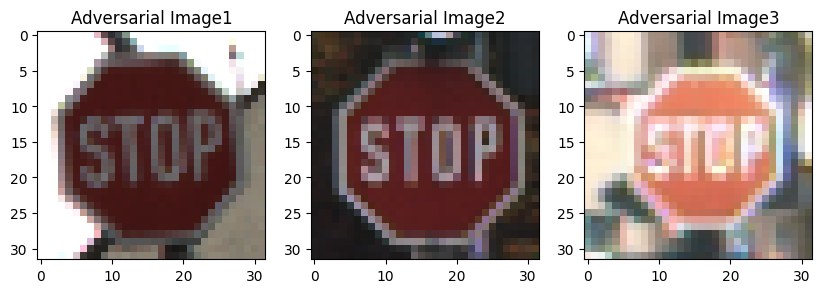

In [51]:
#Get your correct imports
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import CarliniL2Method

STOP_SIGN_LABEL = np.where(signnames == 'Stop')[0][0]
stop_sign_indices = np.where(labels_test == STOP_SIGN_LABEL)[0]
imgs_stop_signs = imgs_test[stop_sign_indices]
labels_stop_signs = labels_test[stop_sign_indices]
labels_stop_signs = to_categorical(labels_stop_signs,43)

#Create the ART classifier
classifier = KerasClassifier(model=model, clip_values=(0, 1))
labels_ = to_categorical(labels_adv)
plt.figure(figsize=(10, 5)) 
plt.subplot(1, 3, 1) 
plt.imshow(imgs_stop_signs[0]) 
plt.title(f'Clean Image1')
plt.subplot(1, 3, 2) 
plt.imshow(imgs_stop_signs[1]) 
plt.title(f'Clean Image2')
plt.subplot(1, 3, 3) 
plt.imshow(imgs_stop_signs[3]) 
plt.title(f'Clean Image3')
plt.show()

#Create the ART attacker
attack_cw = CarliniL2Method(classifier=classifier,
                          max_iter=10,
                          learning_rate=0.1,
                          initial_const=1e0)
imgs_adv_cw_stop_signs = attack_cw.generate(imgs_stop_signs)
#Generate the results
loss_test, accuracy_test = model.evaluate(imgs_adv_cw_stop_signs, labels_stop_signs)
perturbation = np.mean(np.abs((imgs_adv_cw_stop_signs - imgs_stop_signs)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))
#Save the results
plt.figure(figsize=(10, 5))  
plt.subplot(1, 3, 1) 
plt.imshow(imgs_adv_cw_stop_signs[0]) 
plt.title(f'Adversarial Image1')
plt.subplot(1, 3, 2) 
plt.imshow(imgs_adv_cw_stop_signs[1]) 
plt.title(f'Adversarial Image2')
plt.subplot(1, 3, 3) 
plt.imshow(imgs_adv_cw_stop_signs[3]) 
plt.title(f'Adversarial Image3')
plt.show()

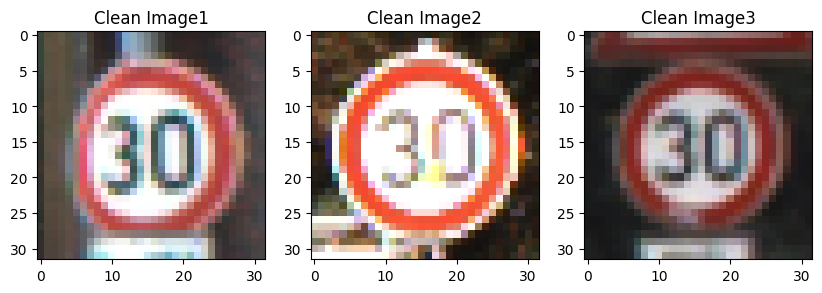

C:\Users\SRUTHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


C&W L_2:   0%|          | 0/720 [00:00<?, ?it/s]

C:\Users\SRUTHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Accuracy on adversarial test data: 2.08%
Average perturbation: 0.02


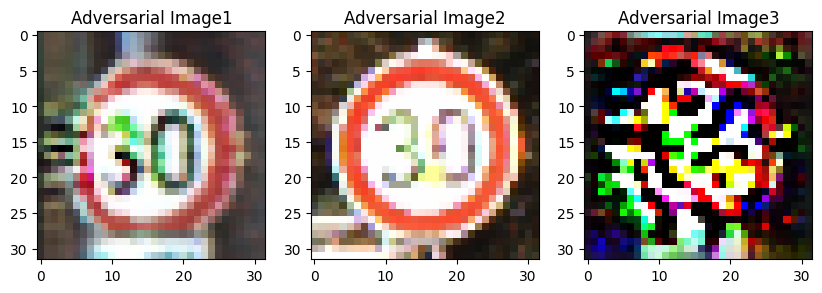

In [50]:
#Get your correct imports
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import CarliniL2Method

STOP_SIGN_LABEL = np.where(signnames == 'Speed limit (30km/h)')[0][0]
stop_sign_indices = np.where(labels_test == STOP_SIGN_LABEL)[0]
imgs_stop_signs = imgs_test[stop_sign_indices]
labels_stop_signs = labels_test[stop_sign_indices]
labels_stop_signs = to_categorical(labels_stop_signs,43)

#Create the ART classifier
classifier = KerasClassifier(model=model, clip_values=(0, 1))
labels_ = to_categorical(labels_adv)
plt.figure(figsize=(10, 5)) 
plt.subplot(1, 3, 1) 
plt.imshow(imgs_stop_signs[0]) 
plt.title(f'Clean Image1')
plt.subplot(1, 3, 2) 
plt.imshow(imgs_stop_signs[1]) 
plt.title(f'Clean Image2')
plt.subplot(1, 3, 3) 
plt.imshow(imgs_stop_signs[3]) 
plt.title(f'Clean Image3')
plt.show()

#Create the ART attacker
attack_cw = CarliniL2Method(classifier=classifier,
                          max_iter=5,
                          learning_rate=0.1,
                          initial_const=1e0)
imgs_adv_cw_stop_signs = attack_cw.generate(imgs_stop_signs)
#Generate the results
loss_test, accuracy_test = model.evaluate(imgs_adv_cw_stop_signs, labels_stop_signs)
perturbation = np.mean(np.abs((imgs_adv_cw_stop_signs - imgs_stop_signs)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))
#Save the results
plt.figure(figsize=(10, 5))  
plt.subplot(1, 3, 1) 
plt.imshow(imgs_adv_cw_stop_signs[0]) 
plt.title(f'Adversarial Image1')
plt.subplot(1, 3, 2) 
plt.imshow(imgs_adv_cw_stop_signs[1]) 
plt.title(f'Adversarial Image2')
plt.subplot(1, 3, 3) 
plt.imshow(imgs_adv_cw_stop_signs[3]) 
plt.title(f'Adversarial Image3')
plt.show()